FLO satış ve pazarlama faaliyetleri için roadmap
belirlemek istemektedir. Şirketin orta uzun vadeli plan
yapabilmesi için var olan müşterilerin gelecekte şirkete
sağlayacakları potansiyel değerin tahmin edilmesi
gerekmektedir.

In [1]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.0 MB/s eta 0:00:00


In [2]:
#Pandas, Numpy, Matplotlib, BetaGeoFitter-GammaGamma from lifetimes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from sklearn.preprocessing import MinMaxScaler

In [74]:
np.random.seed(42)

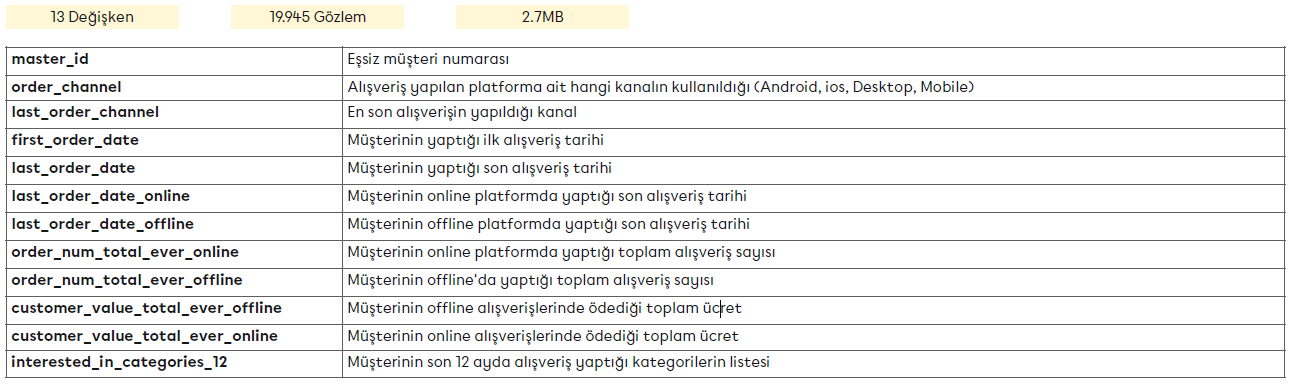

In [4]:
#Veri okuma
df_ = pd.read_csv('/content/flo_data_20k.csv')
df = df_.copy()

In [45]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [8]:
#Boxplot yöntemi ile threshold oluşturma
def outlier_thresholds (dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01).round()
    quartile3 = dataframe[variable].quantile(0.99).round()
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [9]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

## Veri İnceleme

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.110855,4.225647,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.0,1.913913,2.062880,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.0,253.922597,301.532853,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.0,497.321690,832.601886,12.99,149.98,286.46,578.44,45220.13


In [13]:
df.isnull().sum() #eksik değerimiz yok

,0
master_id,0
order_channel,0
last_order_channel,0
first_order_date,0
last_order_date,0
last_order_date_online,0
last_order_date_offline,0
order_num_total_ever_online,0
order_num_total_ever_offline,0
customer_value_total_ever_offline,0


In [11]:
df.head(3)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"


## Threshold fonksiyonu ile baskılama

In [14]:
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

Omnichannel kanalların toplam değerleri

In [60]:
df['total_value'] = df['customer_value_total_ever_offline'] + df['customer_value_total_ever_online']
df['total_sale'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']

Tarih değişkenlerini çevirme, analiz tarihini değiştirme işlemleri

In [20]:
import datetime as dt

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [21]:
for dates in ['first_order_date', 'last_order_date', 'last_order_date_online', 'last_order_date_offline']:
  df[dates] = pd.to_datetime(df[dates])

In [24]:
df['last_order_date'].max()

Timestamp('2021-05-30 00:00:00')

In [25]:
today_date=dt.datetime(2021,6,1)

In [67]:
#########################
# Lifetime Veri Yapısının Hazırlanması
#########################

# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde)
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç
cltv_df = pd.DataFrame()
cltv_df['customer_id'] = df['master_id']
cltv_df['recency']= (df['last_order_date']-df['first_order_date']).dt.days/7
cltv_df['T']= (today_date - df['first_order_date']).dt.days/7
cltv_df['frequency'] = df['total_sale']
cltv_df['monetary'] = df['total_value']/df['total_sale']

In [68]:
cltv_df.head()

,customer_id,recency,T,frequency,monetary
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990


In [72]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,19945.000,95.263,74.589,0.000,50.429,76.571,109.429,433.429
T,19945.000,114.472,74.771,0.714,73.857,93.000,119.429,437.143
frequency,19945.000,4.978,4.125,2.000,3.000,4.000,6.000,57.000
monetary,19945.000,152.098,73.524,22.490,103.650,136.906,182.450,1401.800


## 2. BG-NBD Modelinin Kurulması

In [75]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 76.17, b: 0.00, r: 3.66>

## 3 ay içerisinde müşterilerden beklenen satın alım tahmini

In [76]:
cltv_df['exp_sales_3_month'] = bgf.predict(1*4*3,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

## 6 ay içerisinde müşterilerden beklenen satın alım tahmini

In [78]:
cltv_df['exp_sales_6_month'] = bgf.predict(1*4*6,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [79]:
cltv_df.head()

,customer_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5.000,187.874,0.974,1.948
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209.857,224.857,21.000,95.883,0.983,1.966
2,69b69676-1a40-11ea-941b-000d3a38a36f,52.286,78.857,5.000,117.064,0.671,1.341
3,1854e56c-491f-11eb-806e-000d3a38a36f,1.571,20.857,2.000,60.985,0.700,1.401
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83.143,95.429,2.000,104.990,0.396,0.792


In [90]:
cltv_df.info()
cltv_df['monetary']= cltv_df['monetary'].astype(int)
cltv_df['frequency']= cltv_df['frequency'].astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        19945 non-null  object 
 1   recency            19945 non-null  float64
 2   T                  19945 non-null  float64
 3   frequency          19945 non-null  int64  
 4   monetary           19945 non-null  int64  
 5   exp_sales_3_month  19945 non-null  float64
 6   exp_sales_6_month  19945 non-null  float64
dtypes: float64(4), int64(2), object(1)
memory usage: 1.1+ MB


## Tahmin Sonuçlarının Değerlendirilmesi

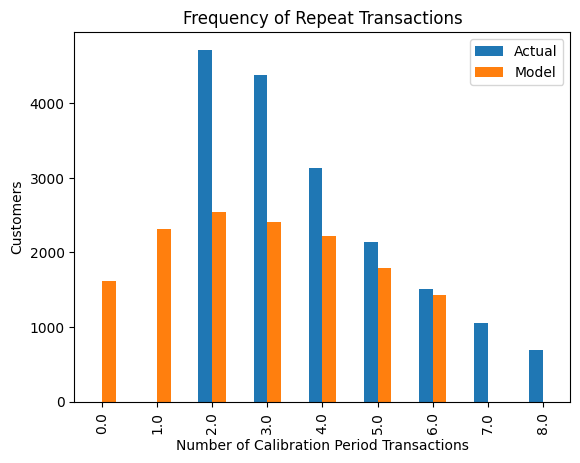

In [80]:
plot_period_transactions(bgf)
plt.show()

## GAMMA-GAMMA Modelinin Kurulması

In [82]:
ggf = GammaGammaFitter(penalizer_coef=0.01)


In [91]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [92]:
cltv_df['exp_average_value'] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                       cltv_df['monetary'])

## 6 Aylık CLTV değerlerinin hesaplanması

In [93]:
cltv=ggf.customer_lifetime_value(bgf,
                                 cltv_df['frequency'],
                                 cltv_df['recency'],
                                 cltv_df['T'],
                                 cltv_df['monetary'],
                                 time=6,
                                 freq='M')

In [119]:
cltv.head()

,clv
0,90.652
1,45.476
2,39.154
3,22.414
4,21.662


In [120]:
cltv_df['cltv'] = cltv

## CLTV Top 20

In [127]:
cltv_df.sort_values('cltv',ascending=False).head(20)

,customer_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.857,7.857,4,1401,1.094,2.189,1448.148,765.404
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.143,13.143,11,758,1.970,3.940,767.258,730.028
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.714,101.000,7,1106,0.722,1.444,1127.098,393.142
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.286,74.571,16,501,1.565,3.131,505.279,381.978
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.429,34.429,8,601,1.265,2.531,611.245,373.568
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.714,67.286,52,164,4.698,9.396,164.481,369.871
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.286,9.429,2,862,0.794,1.588,922.830,353.841
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.714,13.000,17,259,2.781,5.561,261.198,350.776
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.571,58.714,31,228,3.084,6.168,229.073,341.166
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.857,15.571,3,743,0.872,1.743,777.376,327.219


In [134]:
cltv_df['segment']=pd.qcut(cltv_df['cltv'], 4, labels=["D", "C", "B", "A"])

In [135]:
cltv_df.sort_values('segment',ascending=False).head(20)

,customer_id,recency,T,frequency,monetary,exp_sales_3_month,exp_sales_6_month,exp_average_value,cltv,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17.000,30.571,5,187,0.974,1.948,192.727,90.652,A
9273,72af587e-ab2a-11e9-a2fc-000d3a38a36f,16.000,26.857,3,181,0.776,1.552,190.448,71.384,A
9320,c2d6f798-98ce-11ea-b97a-000d3a38a36f,24.000,54.286,2,222,0.521,1.042,239.283,60.201,A
9315,f224e736-f265-11e9-9346-000d3a38a36f,35.429,84.429,3,221,0.498,0.996,232.222,55.839,A
9314,de04ce62-d6b6-11e9-93bc-000d3a38a36f,86.000,96.143,9,149,0.882,1.764,151.599,64.567,A
9309,f83a514c-afbb-11ea-b736-000d3a38a36f,84.000,119.000,8,207,0.717,1.434,210.868,73.031,A
9307,bcd196f4-ca84-11ea-a31e-000d3a38a36f,37.143,37.571,5,153,0.914,1.828,157.838,69.672,A
9301,4e764b86-b032-11e9-9757-000d3a38a36f,107.571,115.714,5,205,0.542,1.084,211.197,55.261,A
9297,20776be6-3dd3-11ea-9e19-000d3a38a36f,78.286,79.286,5,214,0.669,1.337,220.433,71.193,A
9293,3991baf2-94d9-11ea-85df-000d3a38a36f,26.143,55.429,3,202,0.608,1.215,212.379,62.321,A
